# Personal Protective Equipment (PPE) dataset 
## **Objective**
The goal of this project is to develop a robust object detection model using **YOLOv8** to identify and classify **Personal Protective Equipment (PPE)** in images. Ensuring proper usage of PPE is critical in industries such as construction, manufacturing, healthcare, and mining to safeguard workers from potential hazards. This model will assist in automating PPE compliance checks by detecting items like:
- **Helmet**
- **Vests**
- **Gloves**
- **Glasses**
- **Shoes**
  
By leveraging deep learning techniques, we aim to build a system that can be deployed in real-time monitoring or post-processing scenarios to enhance workplace safety.

---

In [8]:
# Install required libraries
!pip install ultralytics opencv-python matplotlib tqdm

# Import necessary modules
import os
import re
import glob
import random
import yaml
from typing import Literal
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [9]:
class CFG:
    SEED = 42
    DATASET_PATH = '/kaggle/input/ppe-v2-ppe-2022-06-12-2-46pm-yolov8/PPE.v2-ppe-2022-06-12-2-46pm.yolov8'
    ARTIFACTS_DATA = '/kaggle/working/dataset'

    # Classes 
    CLASSES = ['Gloves', 'Glasses', 'Shoes', 'Helmet', 'Vest', 'Person']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)
    MODE = ['train', 'test', 'valid']
    # Model
    BASE_MODEL = 'yolov8n'
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    
    #Train

## CREATE YAML FILE
* Create data.yaml used by Yolo

In [10]:
dict_yaml_file = {
    'train': os.path.join(CFG.DATASET_PATH, 'train'),
    'test' : os.path.join(CFG.DATASET_PATH, 'test'),
    'val'  : os.path.join(CFG.DATASET_PATH, 'val'),
    'nc'   : CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
}

In [11]:
def create_yaml_file(file_path = CFG.ARTIFACTS_DATA, data = dict_yaml_file):

    with open(os.path.join(file_path, 'data.yaml'), 'w+') as file:
        yaml.dump(data, file)

In [12]:
def read_yaml_file(file_path = CFG.ARTIFACTS_DATA):
    with open(os.path.join(file_path, 'data.yaml'), 'r') as file:
        try :
            return yaml.safe_load(file)
        except yaml.YAMLError as e:
            print(e)
        except Exception as e:
            print(e)

In [13]:
### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml) 

In [14]:
create_yaml_file()

In [15]:
yaml_data = read_yaml_file()

In [16]:
yaml_data

{'names': ['Gloves', 'Glasses', 'Shoes', 'Helmet', 'Vest', 'Person'],
 'nc': 6,
 'test': '/kaggle/input/ppe-v2-ppe-2022-06-12-2-46pm-yolov8/PPE.v2-ppe-2022-06-12-2-46pm.yolov8/test',
 'train': '/kaggle/input/ppe-v2-ppe-2022-06-12-2-46pm-yolov8/PPE.v2-ppe-2022-06-12-2-46pm.yolov8/train',
 'val': '/kaggle/input/ppe-v2-ppe-2022-06-12-2-46pm-yolov8/PPE.v2-ppe-2022-06-12-2-46pm.yolov8/val'}

In [17]:
print_yaml_data(yaml_data)

names:
- Gloves
- Glasses
- Shoes
- Helmet
- Vest
- Person
nc: 6
test: /kaggle/input/ppe-v2-ppe-2022-06-12-2-46pm-yolov8/PPE.v2-ppe-2022-06-12-2-46pm.yolov8/test
train: /kaggle/input/ppe-v2-ppe-2022-06-12-2-46pm-yolov8/PPE.v2-ppe-2022-06-12-2-46pm.yolov8/train
val: /kaggle/input/ppe-v2-ppe-2022-06-12-2-46pm-yolov8/PPE.v2-ppe-2022-06-12-2-46pm.yolov8/val



## Visualize Images

### visualize one image

In [18]:
def display_one_image(image, print_info = True, axis : Literal['off', 'on'] = 'off'):

    if isinstance(image, str):
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print(f"type : {type(img)}\n")
        print(f"shape : {np.array(img).shape}\n")
    plt.axis(axis)
    plt.show()

type : <class 'PIL.JpegImagePlugin.JpegImageFile'>

shape : (720, 1280, 3)



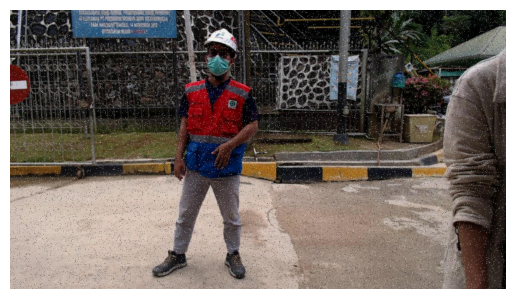

In [19]:
display_one_image(os.path.join(CFG.DATASET_PATH, 'train', 'images', 'image_4_jpg.rf.80f0e5e1cdf17a4c1984693b13904882.jpg')) # axis="off"

### visualise many images

In [20]:
def display_random_images(folder_path, num_images=10, seed=CFG.SEED):

    # fix seed to genere same value
    random.seed(seed)

    # check if the folder exist
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        # Randomly select num_images image files
        selected_files = random.sample(image_files, num_images)

        # Create a subplot grid
        num_cols = 5
        num_rows = (num_images + num_cols - 1) // num_cols
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
        
        for i, file_name in enumerate(selected_files):
            # Open and display the image using PIL
            img = Image.open(os.path.join(folder_path, file_name))
            
            if num_rows == 1:
                ax = axes[i % num_cols]
            else:
                ax = axes[i // num_cols, i % num_cols]
            
            ax.imshow(img)
            ax.axis('off')
            # ax.set_title(file_name)

        # Remove empty subplots
        for i in range(num_images, num_rows * num_cols):
            if num_rows == 1:
                fig.delaxes(axes[i % num_cols])
            else:
                fig.delaxes(axes[i // num_cols, i % num_cols])

        plt.tight_layout()
        plt.show()
    else:
        print(f"not found the folder :: {folder_path}")

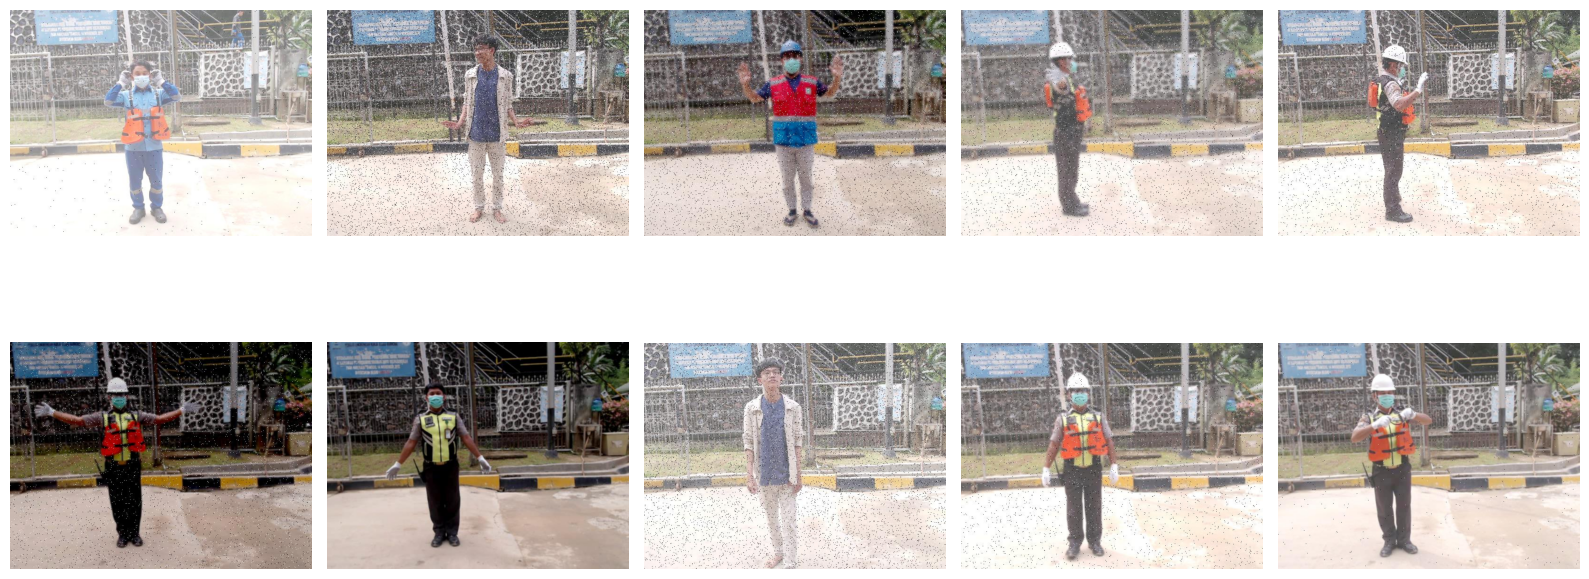

In [21]:
display_random_images(os.path.join(CFG.DATASET_PATH,'train', 'images'))

In [22]:
def plot_image_with_boxes(image_path, label_path):
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Read annotations
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    # Draw bounding boxes
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.split())
        h, w, _ = image.shape
        
        # Convert normalized coordinates to pixel values
        x_min = int((x_center - width / 2) * w)
        y_min = int((y_center - height / 2) * h)
        x_max = int((x_center + width / 2) * w)
        y_max = int((y_center + height / 2) * h)
        
        # Draw rectangle
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
    
    # Plot image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()



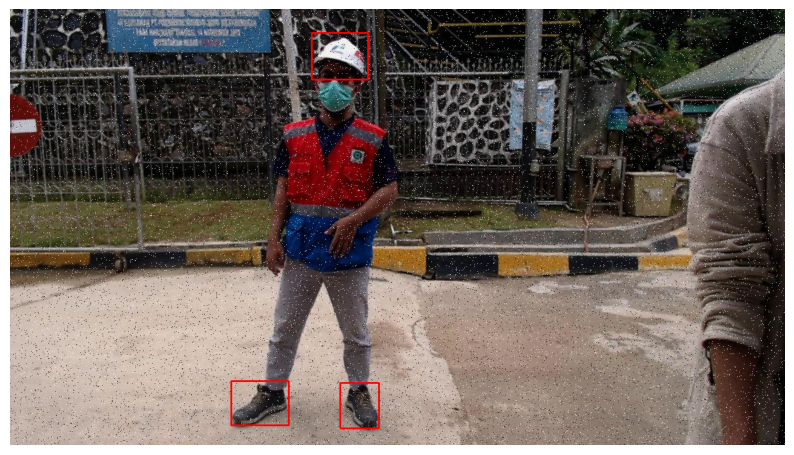

In [23]:
# Example usage
sample_image_path = os.path.join(CFG.DATASET_PATH, 'train', 'images', 'image_4_jpg.rf.80f0e5e1cdf17a4c1984693b13904882.jpg')
sample_label_path = os.path.join(CFG.DATASET_PATH, 'train', 'labels', 'image_4_jpg.rf.80f0e5e1cdf17a4c1984693b13904882.txt')
plot_image_with_boxes(sample_image_path, sample_label_path)

## Dataset statistics¶


In [24]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [25]:
def statistics_of_dataset(folder_path):
    class_info = []
    if os.path.isdir(folder_path):
        
        for mode in CFG.MODE:

            path = os.path.join(folder_path, mode, 'labels')
            # Initialize dict class with zeros
            class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}
            
            
            for file in os.listdir(path):
                
                with open(os.path.join(path, file), 'r') as f:
                    lines = f.readlines()
                    
                    for line in lines:
                        class_count[CFG.CLASSES[int(line[0])]] += 1
                        
            
            data_len = len(os.listdir(path))
            class_info.append({'Mode': mode, **class_count, "N-images": data_len})
            
    else:
        print(f"the folder not found")
        
    dataset_stats_df = pd.DataFrame(class_info)
    return dataset_stats_df


In [ ]:
%%time  
dataset_stats_df = statistics_of_dataset(CFG.DATASET_PATH)

CPU times: user 266 ms, sys: 206 ms, total: 472 ms
Wall time: 2.24 s


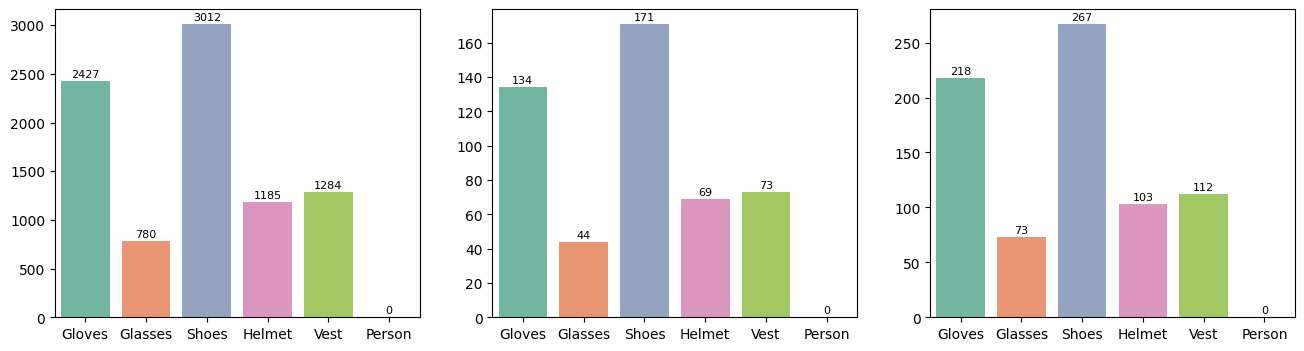

In [27]:
def visualize_statistics(stat_df):
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    for i, mode in enumerate(CFG.MODE):
        sns.barplot(
            data=stat_df[stat_df["Mode"] == mode].drop(columns=["Mode",'N-images']),
            orient= 'v',
            ax=axes[i],
            palette= 'Set2'
        )

        # Add annotations on top of each bar
        for p in axes[i].patches:
            axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')
            
visualize_statistics(dataset_stats_df)

## Pre-processing


In [28]:
def read_image(image_path, format_return : Literal['cv2', 'pil'] = 'cv2'):
        if format_return == 'cv2':
            return cv2.imread(image_path)
        else:
            return Image.open(image_path)
   

In [29]:
# resizing image to be compatible with YOLO8
def resize_image(img, target_size=(640, 640)):
    return cv2.resize(img, target_size)

In [30]:
def normalize_image(img):
    return img/255.0

In [31]:
def convert_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

***adjust_brightness_contrast*** function uses a simple linear transformation to adjust brightness and contrast. Here's the underlying mathematical formula: 

**New Intensity** = (**Contrast** × **Pixels**) + **Brightness**

**Contrast** == **alpha** 

**Brightness** == **beta**

In [32]:
def adjust_brightness_contrast(image, alpha=1.0, beta=0):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)(None)

## Data Augmentation

Data **augmentation** involves generating new variations of existing images to enrich the dataset and improve the robustness of the model.

we are going to do : mirroring, Random cropping, fliping, zoom, rotation and 

In [33]:
def augment_rotation_flip(image):
    # Flip horizontal
    flipped = cv2.flip(image, 1)
    # Rotate 90 degrees
    rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    return flipped, rotated

In [49]:
def scale_image(image, scale_factor=0.5):
    h, w = image.shape[:2]
    new_size = (int(w * scale_factor), int(h * scale_factor))
    return cv2.resize(image, new_size)

In [35]:
def translate_image(image, x_shift, y_shift):
    rows, cols = image.shape[:2]
    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    return cv2.warpAffine(image, M, (cols, rows))

In [36]:
def random_color_jitter(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 0] += random.randint(-10, 10)  # Hue
    hsv[..., 1] += random.randint(-30, 30)  # Saturation
    hsv[..., 2] += random.randint(-30, 30)  # Value
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR) 

In [37]:
def apply_gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

In [38]:
sample_image_path = os.path.join(CFG.DATASET_PATH, 'train', 'images', 'image_4_jpg.rf.80f0e5e1cdf17a4c1984693b13904882.jpg')


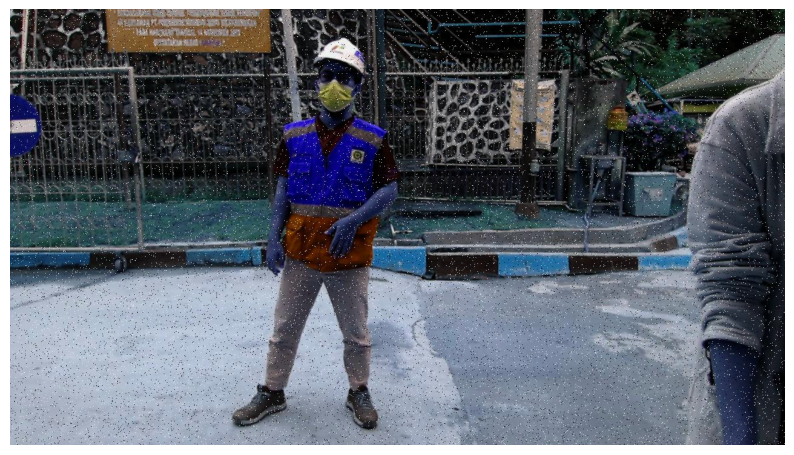

In [42]:
image = read_image(sample_image_path)
  # Plot image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

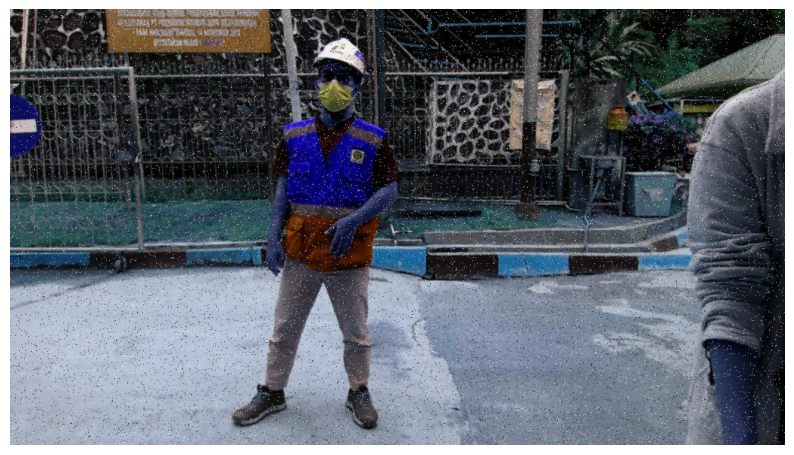

In [41]:
plt.figure(figsize=(10, 10))
plt.imshow(scale_image(image))
plt.axis('off')
plt.show()

type : <class 'PIL.Image.Image'>

shape : (720, 1280, 3)



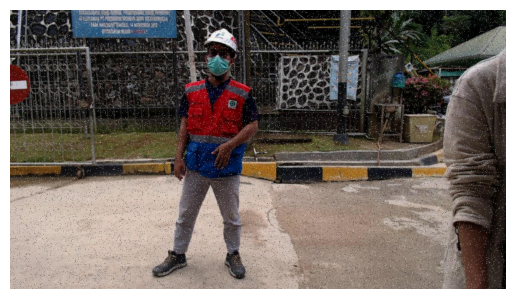

In [43]:
display_one_image(image, print_info = True)


type : <class 'PIL.Image.Image'>

shape : (360, 640, 3)



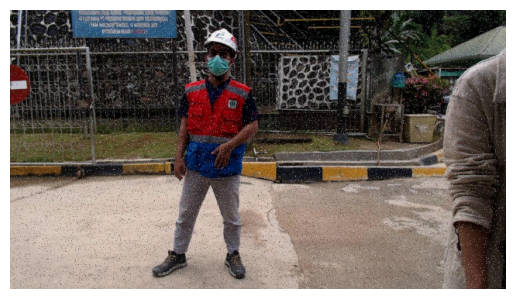

In [50]:
display_one_image(scale_image(image), print_info = True)


type : <class 'PIL.Image.Image'>

shape : (720, 1280, 3)



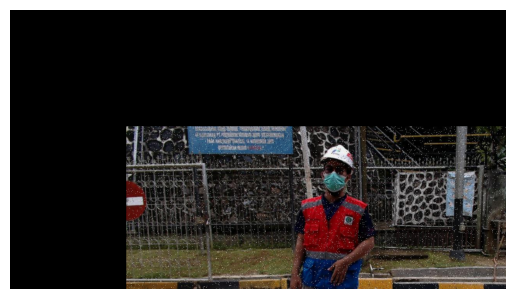

In [47]:
display_one_image(translate_image(image, 300, 300), print_info = True)
